# C. edulis observations in CA

In this notebook we:

- Search the latest GBIF snapshot in the Planetary Computer for pig (Sus scroga) sightings in California, US.
- Count how many records there are per year
- Plot a map with the occurrences
- Export the complete observations dataset

Since looking through all the GBIF observations takes some time (even with the Dask cluster) we do this step in the data access separately.


More info on GBIF dataset:
https://github.com/microsoft/AIforEarthDataSets/blob/main/data/gbif.md



In [3]:
import pystac_client
import planetary_computer as pc

# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

from dask_gateway import GatewayCluster
import dask.dataframe as dd # dataframe optimized for parallel computing

import matplotlib.pyplot as plt

# ----- access items in gbif catalog
save_df = False

In [4]:
# ----- access items in gbif catalog
items = catalog.search(collections=["gbif"]).get_all_items()
items = {x.id: x for x in items}


# ---- select and sign first item
# The snapshot includes all CC-BY licensed data published through GBIF that have coordinates which passed automated quality checks.
gbifitem = list(items.values())[0]
signed_asset = pc.sign(gbifitem).assets["data"]

In [5]:
# ---- initialize dask cluster ---

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
print(cluster.dashboard_link)
# click on link to look at dask cluster

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.0198d87086bf4611a1a308ac2e06a6fc/status


In [6]:
# ---- access GBIF data selecting specific columns ----

df = dd.read_parquet(
    signed_asset.href,
    columns=[
            "species",
            "stateprovince",
            "eventdate",
            "year",
            "month",
            "day",
            "decimallatitude",
            "decimallongitude",
            "institutioncode",
            "coordinateuncertaintyinmeters",
            "coordinateprecision"],
    storage_options=signed_asset.extra_fields["table:storage_options"],
    dataset={"require_extension": None},
)
df

,kingdom,family,genus,class,species,stateprovince,eventdate,year,month,day,decimallatitude,decimallongitude,institutioncode
npartitions=1105,,,,,,,,,,,,,
,object,object,object,object,object,object,object,int32,int32,int32,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
# ---- filter through GBIF data and bring dataframe to memory ---
obs = df.loc[
    (df['species']=='Carpobrotus edulis') &
    (df['stateprovince'] == 'California')
    ].compute()

In [9]:
if (save_df):
    root = '/home/jovyan/msai4earth-esa/iceplant_detection/training_set/'
    obs.to_csv(root+'c_edulis_observations.csv')

## Explore dataset

In [10]:
print('There are', obs.shape[0], ' observations'.)

(427, 13)

## Data by year

In [15]:
obs_by_year = obs.filter(items=['year']).groupby(['year']).size().reset_index(name='count')
print(obs_by_year.head(5))
print(obs_by_year.tail(5))

     year  count
0  1950.0      1
1  1954.0      1
2  1961.0      1
3  1962.0      1
4  1970.0      1
      year  count
28  2018.0     62
29  2019.0     35
30  2020.0     21
31  2021.0     43
32  2022.0      1


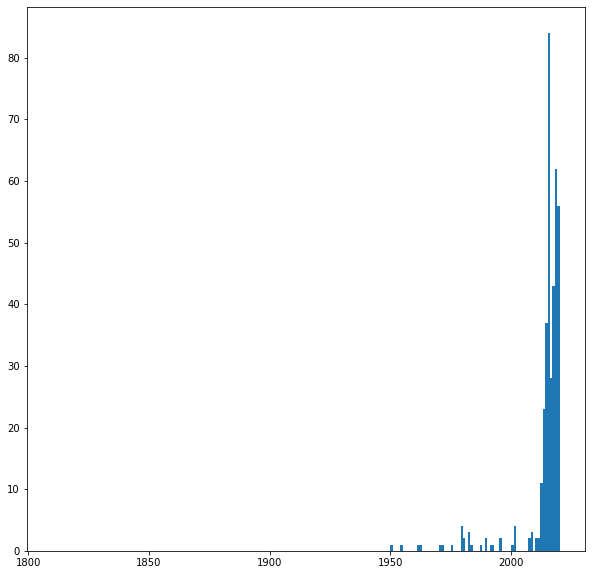

In [14]:
# ---- HISTOGRAM ----

fig, ax = plt.subplots(figsize =(10, 10))
ax.hist(obs.filter(items=['year']), bins = range(1810,2021))
plt.show()